In [1]:
import os
import numpy as np
import mne
import osl
import scipy
import yaml
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import seaborn as sns
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [2]:
clip_num = 50

In [3]:
def encode(x, pca, robust, maxabs, robust2, mu=255):
    x = robust.fit_transform(x.T)
    x = pca.fit_transform(x)
    print(np.mean(x, axis=0))
    print(np.std(x, axis=0))
    
    x = clip(x.T).T
    x = robust2.fit_transform(x)
    x = maxabs.fit_transform(x).T
    print('-------------------')
    print(np.mean(x, axis=1))
    print(np.std(x, axis=1))
    
    
    
    x = x.reshape(-1)
    x = np.sign(x)*np.log(1+mu*np.abs(x))/np.log(1+mu)
    
    bins = np.linspace(-1, 1, mu + 1)
    x = np.digitize(x, bins) - 1

    return x

In [4]:
def decode(x, pca, robust, maxabs, robust2, mu=255, shape=(306, 2857000)):
    x = x / (mu + 1) * 2 - 1
    x = np.sign(x)*((mu+1)**np.abs(x)-1) / mu
    
    x = x.reshape(shape)
    x = maxabs.inverse_transform(x.T)
    x = robust2.inverse_transform(x)
    x = pca.inverse_transform(x)
    x = robust.inverse_transform(x)
    
    return x.T

In [5]:
def clip(x):
    shape = x.shape
    
    sorted_ = np.sort(x)
    clip_vals = sorted_[:, -clip_num]
    
    for i in range(shape[0]):
        x[i, :] = np.clip(x[i, :], -clip_vals[i], clip_vals[i])

    return x

In [6]:
outdir = os.path.join('rich_data', 'subj2', 'sess4', 'oslpy_deb')

In [7]:
path = os.path.join(outdir, 'task_part1_4_tsss_preproc_raw.fif')
raw = mne.io.read_raw_fif(path, preload=True)

Opening raw data file rich_data/subj2/sess4/oslpy_deb/task_part1_4_tsss_preproc_raw.fif...
    Range : 58000 ... 1401999 =     58.000 ...  1401.999 secs
Ready.
Opening raw data file /Users/ricsi/Documents/GitHub/MEG-transfer-decoding/scripts/rich_data/subj2/sess4/oslpy_deb/task_part1_4_tsss_preproc_raw-1.fif...
    Range : 1402000 ... 2745999 =   1402.000 ...  2745.999 secs
Ready.
Opening raw data file /Users/ricsi/Documents/GitHub/MEG-transfer-decoding/scripts/rich_data/subj2/sess4/oslpy_deb/task_part1_4_tsss_preproc_raw-2.fif...
    Range : 2746000 ... 2914999 =   2746.000 ...  2914.999 secs
Ready.
Reading 0 ... 2856999  =      0.000 ...  2856.999 secs...


In [8]:
raw_data = raw.get_data(picks='meg')

In [9]:
data = clip(raw_data)

In [10]:
pca = PCA(306)
robust_scaler = RobustScaler()
robust_scaler2 = RobustScaler()
maxabs = MaxAbsScaler()

In [35]:
%matplotlib widget
plt.hist(pca_data.reshape(-1), bins=256)
#plt.xlim(-1, 1)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

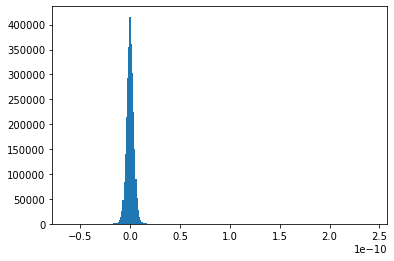

In [102]:
plt.hist(raw_data[100], bins=256)
#plt.xlim(-1, 1)
plt.show()

In [11]:
encoded = encode(raw_data, pca, robust_scaler, maxabs, robust_scaler2)

[ 7.64013750e-18  2.19454991e-17 -2.71384051e-17 -6.84428985e-18
 -1.59169531e-17  2.46513812e-17 -4.77508594e-19  5.65051836e-18
 -4.57612402e-18  7.48096797e-18  1.76280256e-17 -3.50172969e-18
  8.51556992e-18 -3.38235254e-18 -1.40069188e-17 -8.99307852e-18
  8.99307852e-18 -4.92430737e-18 -8.15743848e-19 -4.25778496e-18
 -3.35648749e-17 -3.66089922e-18  4.83477451e-18  4.94917761e-18
 -9.47058711e-18  4.48161712e-18  1.11717115e-17 -1.15397910e-18
 -1.43700242e-17 -4.91435928e-18  6.82936770e-18 -7.85899561e-19
  1.60363303e-17 -1.91799285e-17 -2.67106370e-18 -1.22560539e-17
 -7.70480012e-18 -6.28719649e-18 -1.01321355e-17 -9.29152139e-18
  1.10622824e-17 -1.59269012e-17 -8.35640039e-19 -9.63224367e-18
  1.19128446e-17 -4.77508594e-18  9.72923760e-18  7.45112368e-18
 -4.67560498e-18  3.16349443e-18  1.57478355e-17  9.85607582e-18
  1.45242197e-18  1.97967105e-17 -1.11020748e-17  5.41176406e-18
  1.07041510e-17  5.72015503e-18  3.81509470e-18 -6.95371890e-18
 -7.01340747e-18 -1.64442

In [12]:
%matplotlib widget
plt.plot(encoded[50000:55000])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [45]:
encoded = encoded.reshape((306, 2857000))

In [46]:
%matplotlib widget
plt.hist(encoded[1], bins=256)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [47]:
%matplotlib widget
plt.hist(encoded[-1], bins=256)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [53]:
decoded = decode(encoded.reshape(-1), pca, robust_scaler, maxabs, robust_scaler2)

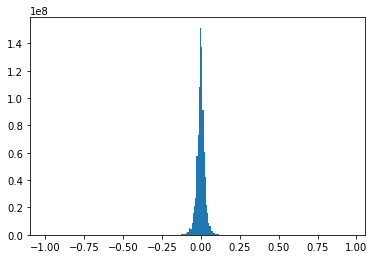

In [118]:
plt.hist(decoded, bins=256)
plt.show()

In [54]:
errors = []
for i in range(306):
    data_mean = np.mean(np.abs(raw_data[i]))
    diff = np.mean(np.abs(raw_data[i] - decoded[i]))
    
    errors.append(diff/data_mean)

In [55]:
%matplotlib widget
plt.hist(errors, bins=306)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [60]:
np.mean(np.abs(data - decoded))

2.2653147623638926e-13

In [61]:
np.mean(np.abs(data))

2.6966176323667345e-12

In [64]:
diff = data - decoded

In [63]:
%matplotlib widget
plt.plot(data[10, 50000:52000], 'r', decoded[10, 50000:52000], 'b', linewidth=0.2)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [70]:
%matplotlib widget
plt.hist(diff.reshape(-1), bins=10000)
plt.xlim((-2e-12, 2e-12))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(-2e-12, 2e-12)